**Eric Xiang #90612029**

**Nishchay Ranjan #25257296**

**Aryan Ghasemi #33475542**

**Malcom Maxwell #97241418**

# Pulsar Prediction Model

## Introduction

A pulsar is a magnetized rotating neutron star that emits electromagnetic radiation from its magnetic poles. The data set we will be using contains pulsar candidates collected during what's known as the "High Time Resolution Universe Survey". Pulsar emission spreads across the sky and produces a detectable pattern of broadband radio emission. However in practice almost all detections are caused by radio frequency interference and noise, making legitimate signals hard to find. Using this dataset, we will be creating an engine to try to predict whether a star is a pulsar or other. We want to ask: how accurately can our model predict if a star is a pulsar star? We will be using the HTRU2 data set, which contains 17,897 observations which were measured using RFI/noise.

Our data can be found here: https://archive.ics.uci.edu/ml/datasets/HTRU2

## Method & Results

Using UCI Machine Learning Repository's dataset on Pulsar stars, we plan to conduct a classification analysis using K-Nearest Neighbors to determine whether a star is a pulsar star or whether it is not. We will try to predict the variable Class using the predictors that are most suited to identifying a pulsar star, by training our KNN-Classification algorithm on those predictors. The final Pulsar KNN Model is going to be visualized as a scatterplot, with clear labels, coloured points depending on the class, and coloured points that indicates the decision of the classifier. Which will be compared to the true classification of the star to see whether our classification is good or bad. We have nine columns in our data set. 1) Mean of the integrated profile 2) Standard deviation of the integrated profile 3) Excess kurtosis of the integrated profile 4) Skewness of the integrated profile 5) Mean of the DM-SNR curve 6) Standard deviation of the DM-SNR curve 7) Excess kurtosis of the DM-SNR curve 8) Skewness of the DM-SNR curve 9) The classification of the observation. These will each be vetted to see which one will be best to distinguish pulsar stars from non-pulsar stars.


#### Loading in initial libraries

In [1]:
library(tidyverse)
library(GGally)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(patchwork)
options(repr.matrix.max.rows = 8)
options(repr.plot.width=15, repr.plot.height=19)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workfl

## Wrangling Dataset

In this part of the project, we want to wrangle our dataset so that it is tidy, and will be convenient for use later on when we are trying to make our classification model. We will do this by loading in the data, and applying the correct mutations to it so that it is tidy, which includes adding column names, changing certain variables to be a different class, renaming some values, and making the data easier to work with when typing.


In [2]:
# Loading in dataset, adding column headers, and renaming "Class" values from 0 and 1 to is_pulsar or is_not_pulsar to tidy up data

paste("Table 1: Pulsar Data")

pulsar_data <- read_csv("https://raw.githubusercontent.com/KoiYouu/dcsi100_group_project/main/HTRU2/HTRU_2.csv", col_names = FALSE, show_col_types = FALSE)
colnames(pulsar_data) <- c("Mean_of _the_integrated_profile", 
                           "Standard_deviation_of_the_integrated_profile",
                           "Excess_kurtosis_of_the_integrated_profile",
                           "Skewness_of_the_integrated_profile",
                           "Mean_of_the_DM-SNR_curve",
                           "Standard_deviation_of_the_DM-SNR_curve",
                           "Excess_kurtosis_of_the_DM-SNR_curve",
                           "Skewness_of_the_DM-SNR_curve",
                           "Class")

pulsar_data <- mutate(pulsar_data, Class = ifelse(Class == 1, "is_pulsar", "is_not_pulsar"), Class = as.factor(Class))
pulsar_data

[1] "Table 1: Pulsar Data"

Mean_of _the_integrated_profile,Standard_deviation_of_the_integrated_profile,Excess_kurtosis_of_the_integrated_profile,Skewness_of_the_integrated_profile,Mean_of_the_DM-SNR_curve,Standard_deviation_of_the_DM-SNR_curve,Excess_kurtosis_of_the_DM-SNR_curve,Skewness_of_the_DM-SNR_curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,is_not_pulsar
102.5078,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,is_not_pulsar
103.0156,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,is_not_pulsar
136.7500,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,is_not_pulsar
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,is_not_pulsar
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,is_not_pulsar
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,is_not_pulsar
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,is_not_pulsar


In [3]:
# Renaming column headers to be easier to use when coding

paste("Table 2: Pulsar Data With Updated Column Names")

colnames(pulsar_data) <- c('mean_profile', 'std_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr',
               'std_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr', 'class')
pulsar_data

[1] "Table 2: Pulsar Data With Updated Column Names"

mean_profile,std_profile,kurtosis_profile,skewness_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,is_not_pulsar
102.5078,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,is_not_pulsar
103.0156,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,is_not_pulsar
136.7500,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,is_not_pulsar
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,is_not_pulsar
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,is_not_pulsar
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,is_not_pulsar
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,is_not_pulsar


## Determining Which Variables To Use In Our KNN-Classification Algorithm

The way we will determine which variables to use in our KNN-Classification algorithm is seeing which variables seem to differ a lot in value when a star is either a pulsar or not a pulsar star. The way we will do this is by using a violin graph to see which quantitative values would be the most useful for differentiating pulsar stars from non pulsar stars. We will also be splitting the data so that we are making proper predictive models without "double counting" the data and without seeing the test data. We can also see that there are 12168 observations that aren't pulsar stars, and 1255 that are pulsar_stars in our training dataset and the included 1 variable stats of our dataset, from this see that we may have to upscale our data as we see there is a large imbalance of pulsar stars to non-pulsar stars. In order to create a good classification model you generally should have a balanced set of data in order to make the best model. However, in our case we will not upscale our data which will be explained at the end of the project, as it will make more sense.



In [4]:
# Creating the training / testing split

set.seed(2022)
pulsar_split <- initial_split(pulsar_data, prop = 3/4, strata = class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

In [5]:
# Collecting the basic data on our training set

pulsar_info <- pulsar_train %>%
    count(class)
paste("Table 3: Count of Types Of Stars In Our Dataset")
pulsar_info

paste("Table 4: One Variable Stats of Our Data")
summary(pulsar_train)



[1] "Table 3: Count of Types Of Stars In Our Dataset"

class,n
<fct>,<int>
is_not_pulsar,12168
is_pulsar,1255


[1] "Table 4: One Variable Stats of Our Data"

  mean_profile      std_profile    kurtosis_profile   skewness_profile 
 Min.   :  5.812   Min.   :24.79   Min.   :-1.87601   Min.   :-1.7647  
 1st Qu.:100.855   1st Qu.:42.37   1st Qu.: 0.02892   1st Qu.:-0.1879  
 Median :114.883   Median :46.92   Median : 0.22497   Median : 0.2019  
 Mean   :110.952   Mean   :46.53   Mean   : 0.48302   Mean   : 1.7840  
 3rd Qu.:126.953   3rd Qu.:51.02   3rd Qu.: 0.47307   3rd Qu.: 0.9398  
 Max.   :192.617   Max.   :98.78   Max.   : 8.06952   Max.   :68.1016  
   mean_dmsnr         std_dmsnr      kurtosis_dmsnr   skewness_dmsnr    
 Min.   :  0.2132   Min.   :  7.37   Min.   :-3.139   Min.   :  -1.965  
 1st Qu.:  1.9293   1st Qu.: 14.46   1st Qu.: 5.745   1st Qu.:  34.600  
 Median :  2.8043   Median : 18.47   Median : 8.424   Median :  82.993  
 Mean   : 12.7936   Mean   : 26.43   Mean   : 8.287   Mean   : 104.710  
 3rd Qu.:  5.5075   3rd Qu.: 28.59   3rd Qu.:10.695   3rd Qu.: 139.289  
 Max.   :223.3921   Max.   :109.71   Max.   :34.540   Max.

In [6]:
# Creating the violin plots

options(repr.plot.width=15, repr.plot.height=19)

mean_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=mean_profile, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Mean of the integrated profile")+
    theme(text = element_text(size = 15))

std_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=std_profile, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Standard deviation of the integrated profile")+
    theme(text = element_text(size = 15))

kurtosis_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=kurtosis_profile, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Excess kurtosis of the integrated profile")+
    theme(text = element_text(size = 15))

skewness_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=skewness_profile, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Skewness of the integrated profile")+
    theme(text = element_text(size = 15))

mean_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=mean_dmsnr, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Mean of the DM-SNR curve")+
    theme(text = element_text(size = 15))

std_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=std_dmsnr, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Standard deviation of the DM-SNR curve")+
    theme(text = element_text(size = 15))

kurtosis_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=kurtosis_dmsnr, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Excess kurtosis of the DM-SNR curve")+
    theme(text = element_text(size = 15))

skewness_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=skewness_dmsnr, fill = class)) + 
    geom_violin(width=1.7, position = "dodge")+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Star Type", y = "Skewness of the DM-SNR curve")+
    theme(text = element_text(size = 15))

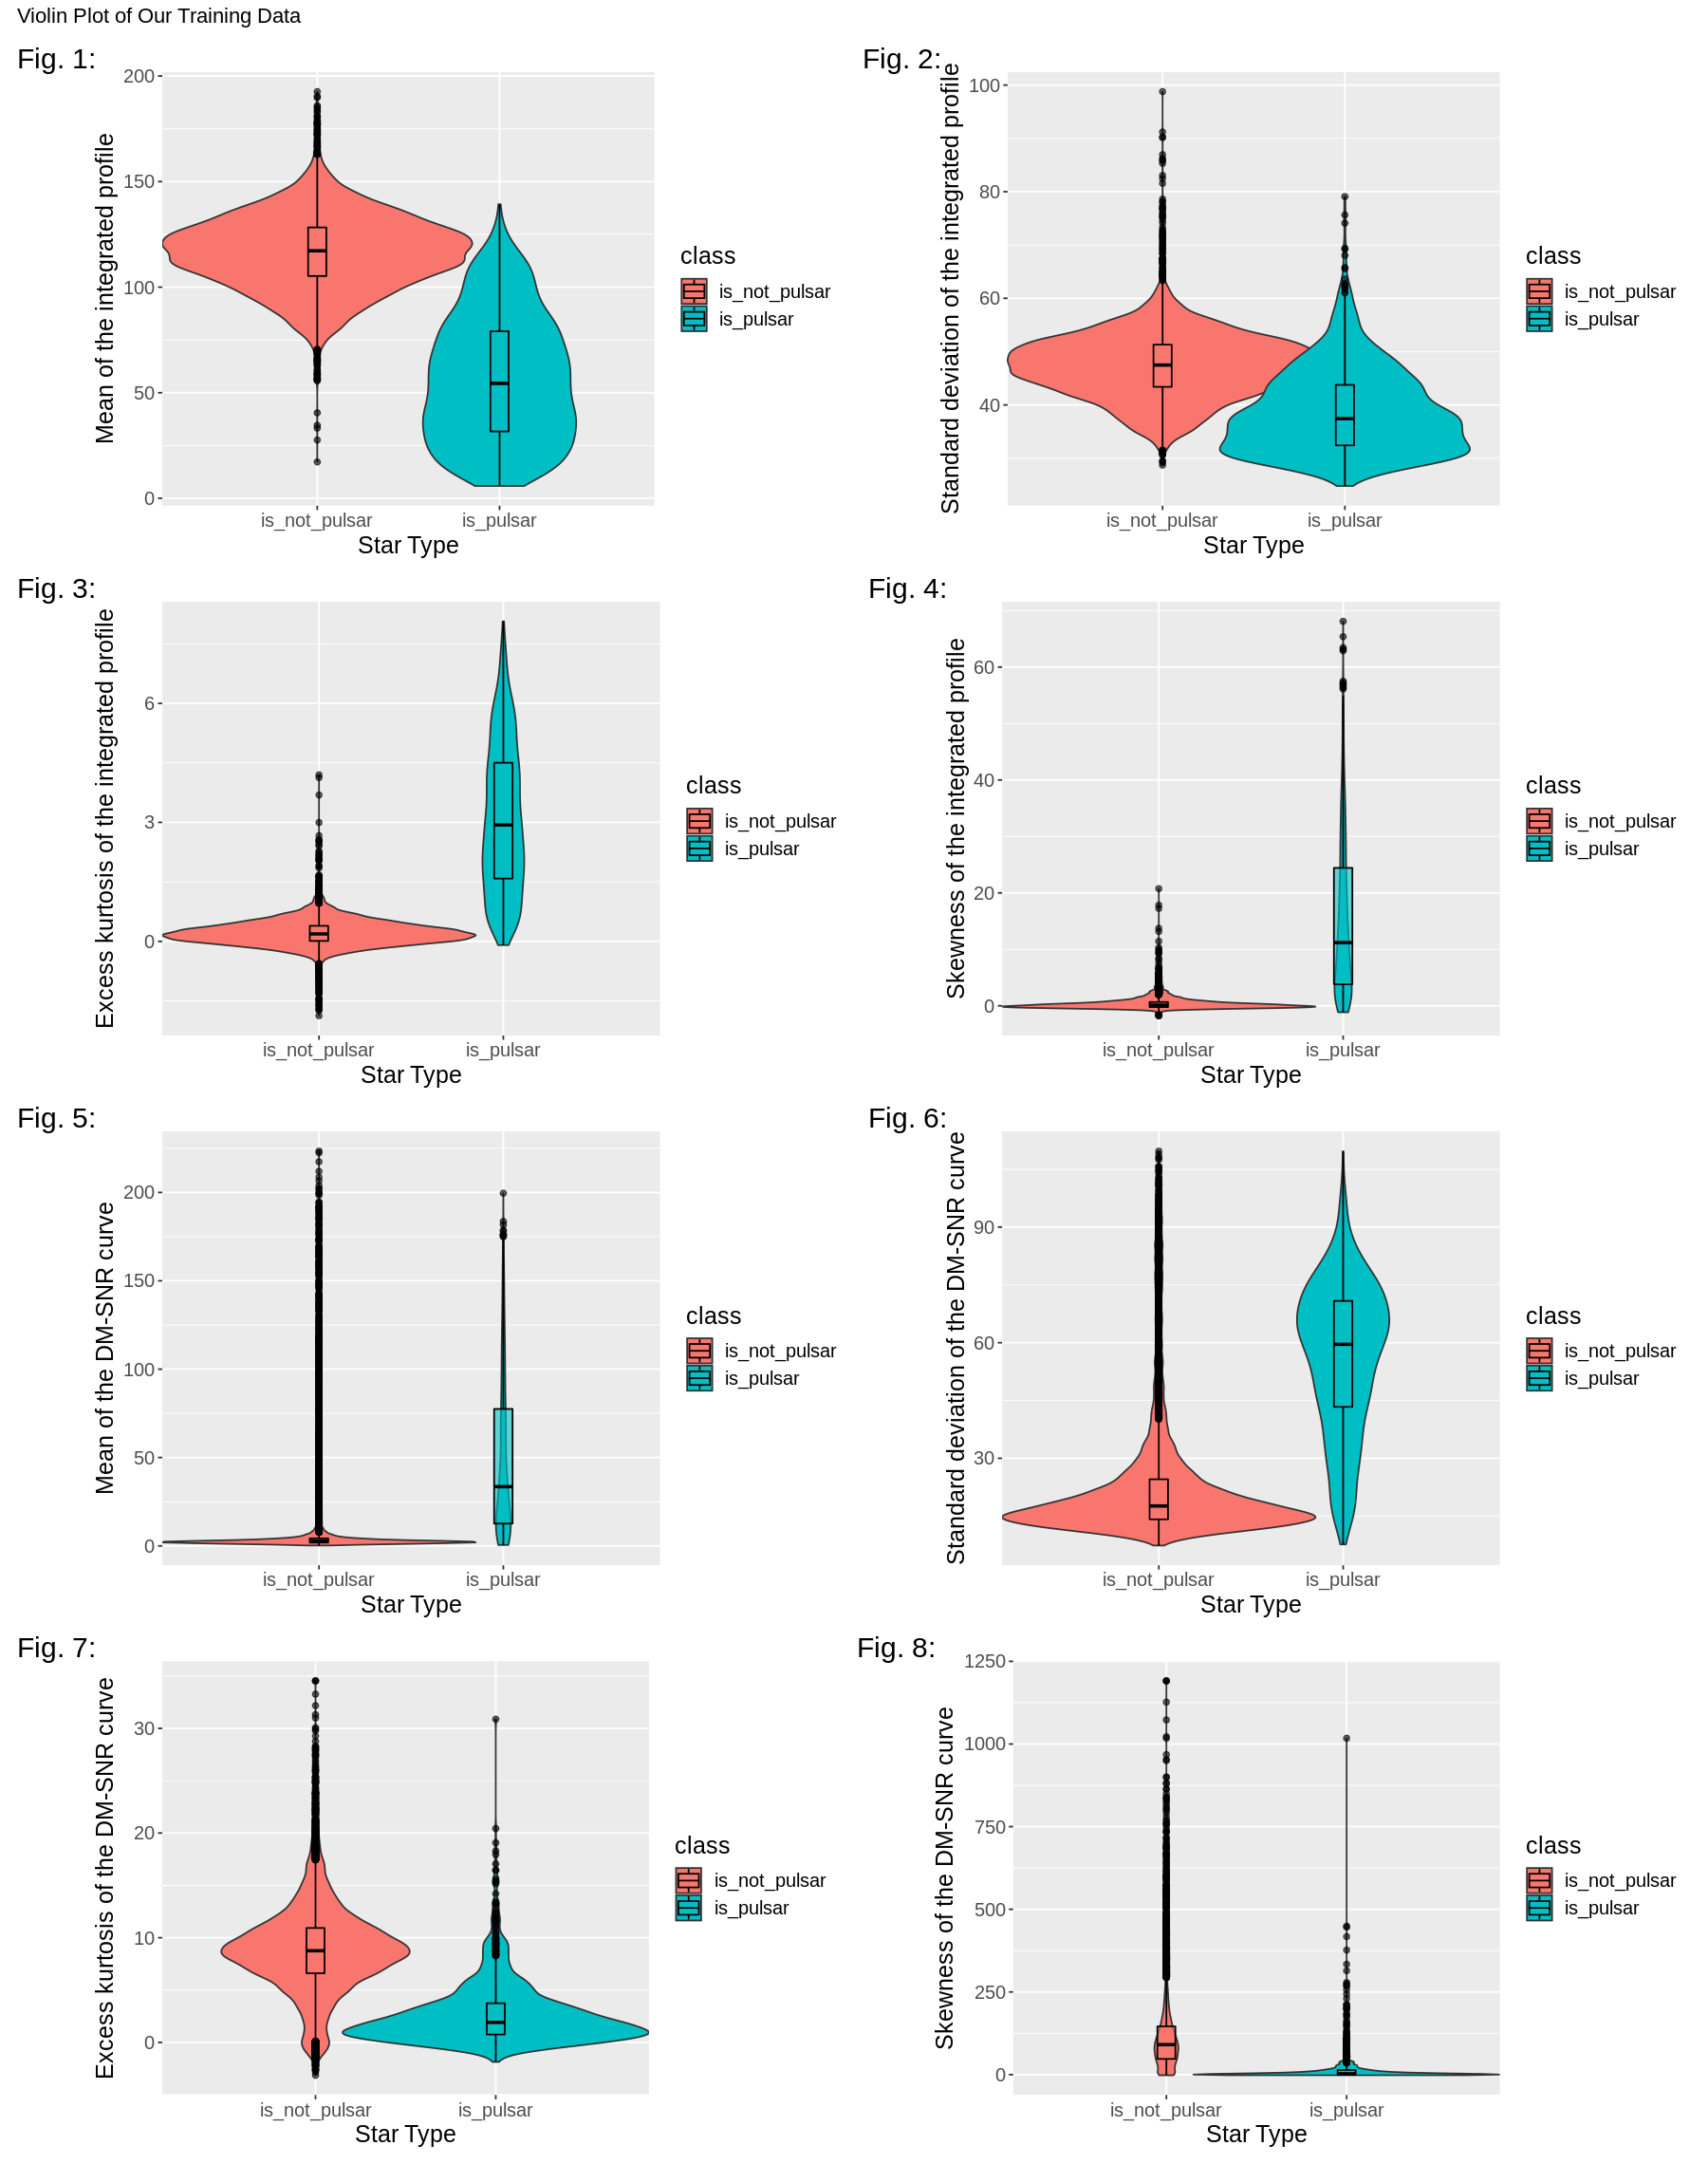

In [7]:
# Making a subplot of the Violin graphs

options(warn= -1)
(mean_profile_pulsar | std_profile_pulsar)/
(kurtosis_profile_pulsar | skewness_profile_pulsar)/
(mean_dmsnr_pulsar | std_dmsnr_pulsar)/
(kurtosis_dmsnr_pulsar | skewness_dmsnr_pulsar) + 

plot_annotation(
    tag_levels = "1", tag_prefix = 'Fig. ',tag_sep = '.', tag_suffix = ':',
    title = 'Violin Plot of Our Training Data')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



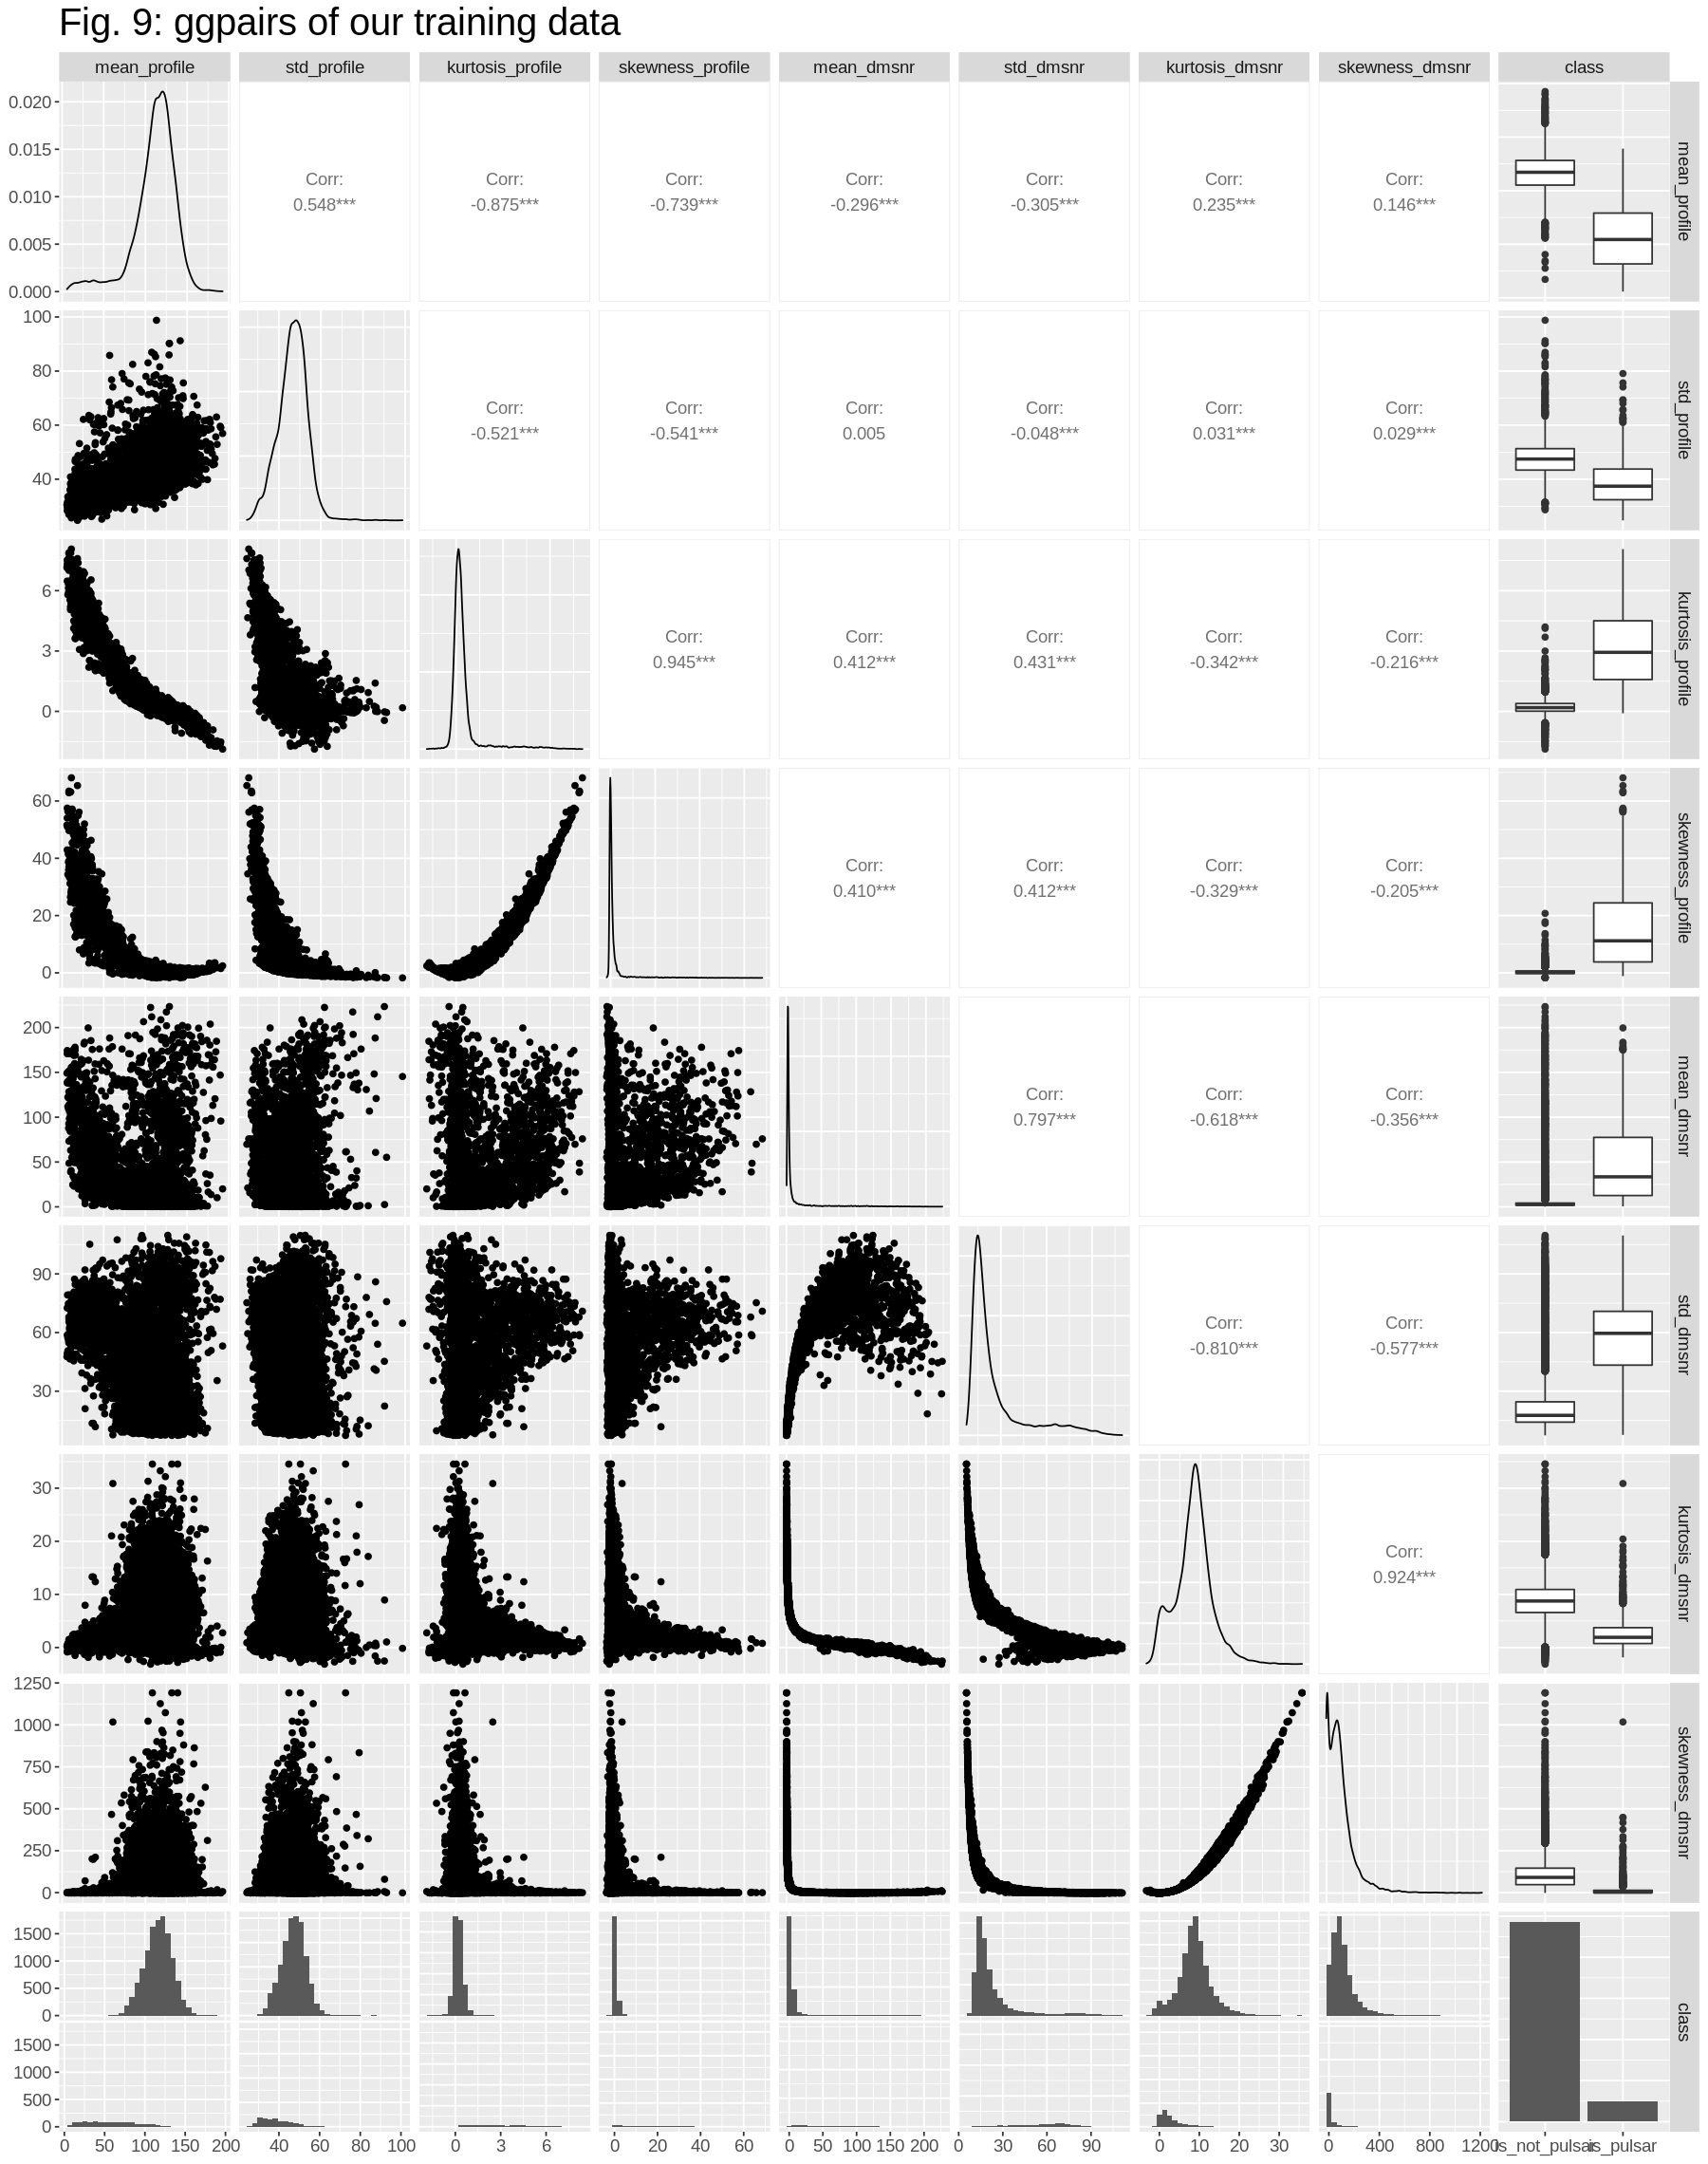

In [8]:
# IGNORE WARNINGS, wanted to use binwidth of 30 anyways

ggpairs(pulsar_train) + 
ggtitle("Fig. 9: ggpairs of our training data")+
theme(text = element_text(size = 14), title = element_text(size = 20))

## Preliminary Data Exploratory Analysis
After looking at these violin plots we can see that the "Mean of the integrated profile", "Excess kurtosis of the integrated profile", "Excess kurtosis of the DM-SNR curve", and "Standard deviation of the DM-SNR curve" would be the best categories to train our engine on. This is backed up further when looking at our ggpairs graph as we see that there is a clear difference in these statistics when a star is a pulsar star vs a non-pulsar star. Therefore these 4 variables will be used in creating our KNN Classification engine.

## Creating the KNN Classification Engine / Finding The Best Value of $K$

Before we even begin creating our KNN classification engine there are a few things we must do first. That is creating the recipe, making the specifications of our engine, and creating our cross-validation specifications. 
 
When creating the recipe we specify we are trying to classify the "class" variable, using the 4 previous variables we determined before; "Mean of the integrated profile", "Excess kurtosis of the integrated profile", "Excess kurtosis of the DM-SNR curve", and "Standard deviation of the DM-SNR curve". Next we then have to add to our recipe our scaling and centering of our data, otherwise certain pieces of data will have more voting power then other pieces of data. 
 
Next we make our classification engine specifications, where we tell our engine to classify datapoints using the K-nearest neighbours engine. 
 
Finally we make our cross validation specifications with 10 folds. Now we can move onto creating our KNN classification engine.
 
When creating a KNN classification engine, we need to consider what the best value of $K$ is, to do so we must first test out a large range of K values by doing cross-validation and comparing the accuracies of each value of $K$ to find which value of $K$ gets us the highest accuracy. In our case we will be testing values for $K$ from $1$ to $10$, as each extra value of $K$ we test gets much more computationally expensive and would take very long. After finding the best $K$ value, by using v-fold cross validation with 10 folds to test for the best value of $K$, then we will use that determined $K$ value to create our final classification engine. 



In [9]:
# Creating the recipe, vfold, and engine

set.seed(2022)

pulsar_recipe <- recipe(class ~ mean_profile + kurtosis_profile + kurtosis_dmsnr + std_dmsnr, data = pulsar_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)

gridvals <- tibble(neighbors = seq(1, 10))

pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")      

In [10]:
# Putting it all together in a worklist and collecting the metrics to graph

set.seed(2022)

pulsar_results <- workflow() |>
  add_recipe(pulsar_recipe) |>
  add_model(pulsar_spec) |>
  tune_grid(resamples = pulsar_vfold, grid = gridvals) |>
  collect_metrics()


[1] "Table 5: Accuracy of Each K Value"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.9786181,10,0.001453227,Preprocessor1_Model07
8,accuracy,binary,0.9786181,10,0.001453227,Preprocessor1_Model08
5,accuracy,binary,0.9786181,10,0.001575474,Preprocessor1_Model05
6,accuracy,binary,0.9786181,10,0.001575474,Preprocessor1_Model06
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,accuracy,binary,0.9772771,10,0.001544737,Preprocessor1_Model03
4,accuracy,binary,0.9772771,10,0.001544737,Preprocessor1_Model04
1,accuracy,binary,0.9666981,10,0.001471433,Preprocessor1_Model01
2,accuracy,binary,0.9666981,10,0.001471433,Preprocessor1_Model02


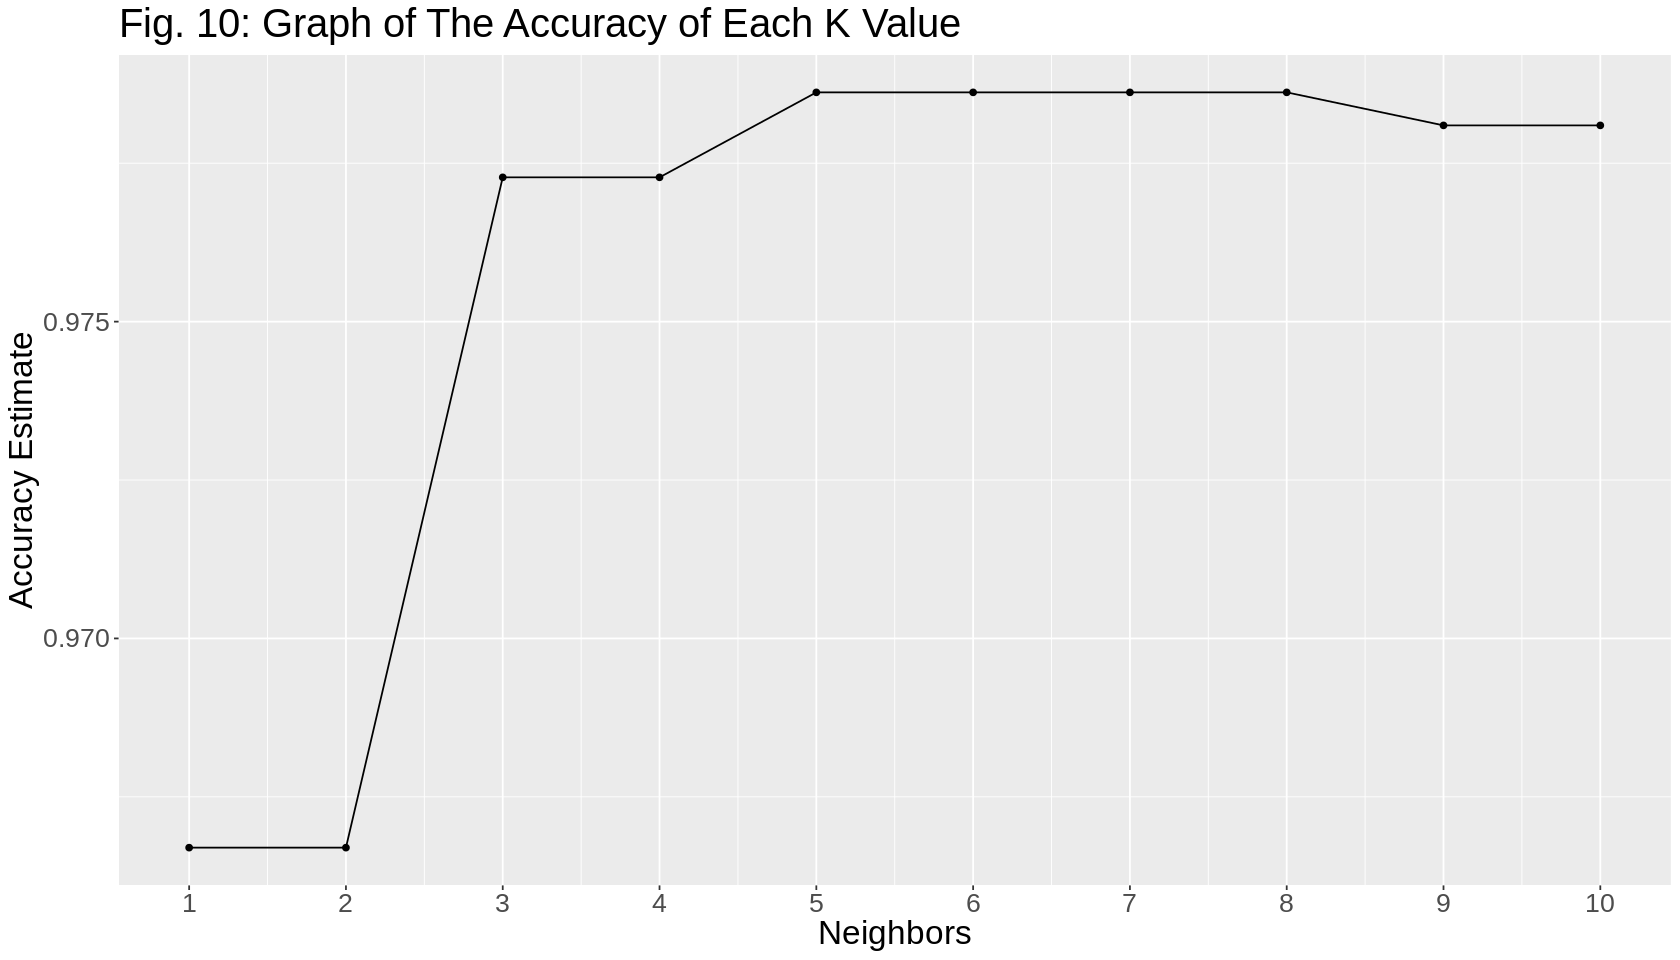

In [11]:
# Arranging the metrics by highest accuracy and plotting

paste("Table 5: Accuracy of Each K Value")
accuracies <- pulsar_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
accuracies

options(repr.plot.height = 8, repr.plot.width = 14)

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = 1:10) +
    theme(text = element_text(size = 20)) +
    ggtitle("Fig. 10: Graph of The Accuracy of Each K Value")

cross_val_plot

## Creating The Final KNN Classification Engine

As seen in the graph above the best $K$ neighbours seem to be either 5, 6, 7, and 8. In our case we will choose $K = 7$ as it seems to be a good middle value out of the 4 options. So now we will recreate our KNN classification engine but this time with $K = 7$ and collect the accuracy and confusion matrix of our predictions to see how accurate it is. We will then do a graph to visualize how frequently our KNN classification engine gets the correct or wrong classification. This time around nothing much changes, as we just reuse the same recipe, but specify $K = 7$ in our engine specifications.

In [12]:
# Adding everything together in the new knn_spec, adding it to a workflow, getting the engine to predict on our test data, collecting the accuracy, 
# and finally making the confusion matrix and plotting the graph

set.seed(2022)

pulsar_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

pulsar_fit <- workflow() |>
  add_recipe(pulsar_recipe) |>
  add_model(pulsar_final_spec) |>
  fit(data = pulsar_train)

pulsar_fit

pulsar_test_predictions <- predict(pulsar_fit, pulsar_test) |>
    bind_cols(pulsar_test)

pulsar_correctness <- predict(pulsar_fit, pulsar_test) |>
    bind_cols(pulsar_test) |>
    mutate(correct = .pred_class==class) |>
    bind_cols(tibble(observation = 1:4475))

accuracy <- pulsar_test_predictions |>
    metrics(truth = class, estimate = .pred_class)|>
    select(.metric, .estimate) |> 
    head(1)


confusion_matrix <- pulsar_test_predictions |>
  conf_mat(truth = class, estimate = .pred_class)

options(repr.plot.height = 10, repr.plot.width = 24)

pulsar_graph <- pulsar_correctness%>%
    ggplot(aes(x=observation, y =std_dmsnr, colour = correct))+
    geom_point(alpha = 0.8)+
    labs(x = "Unique Observation #", y = "True Classification", colour = "Correct Classification")+
    ggtitle("Fig. 11: Graph of Our Classification Engines Predictions")+
    theme(text = element_text(size = 20))

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02130671
Best kernel: rectangular
Best k: 7

[1] "Table 5: Accuracy of Our KNN Classification Engine"

.metric,.estimate
<chr>,<dbl>
accuracy,0.9794413


[1] "Table 6: Confusion Matrix of Our KNN Classification Engine"

               Truth
Prediction      is_not_pulsar is_pulsar
  is_not_pulsar          4064        65
  is_pulsar                27       319

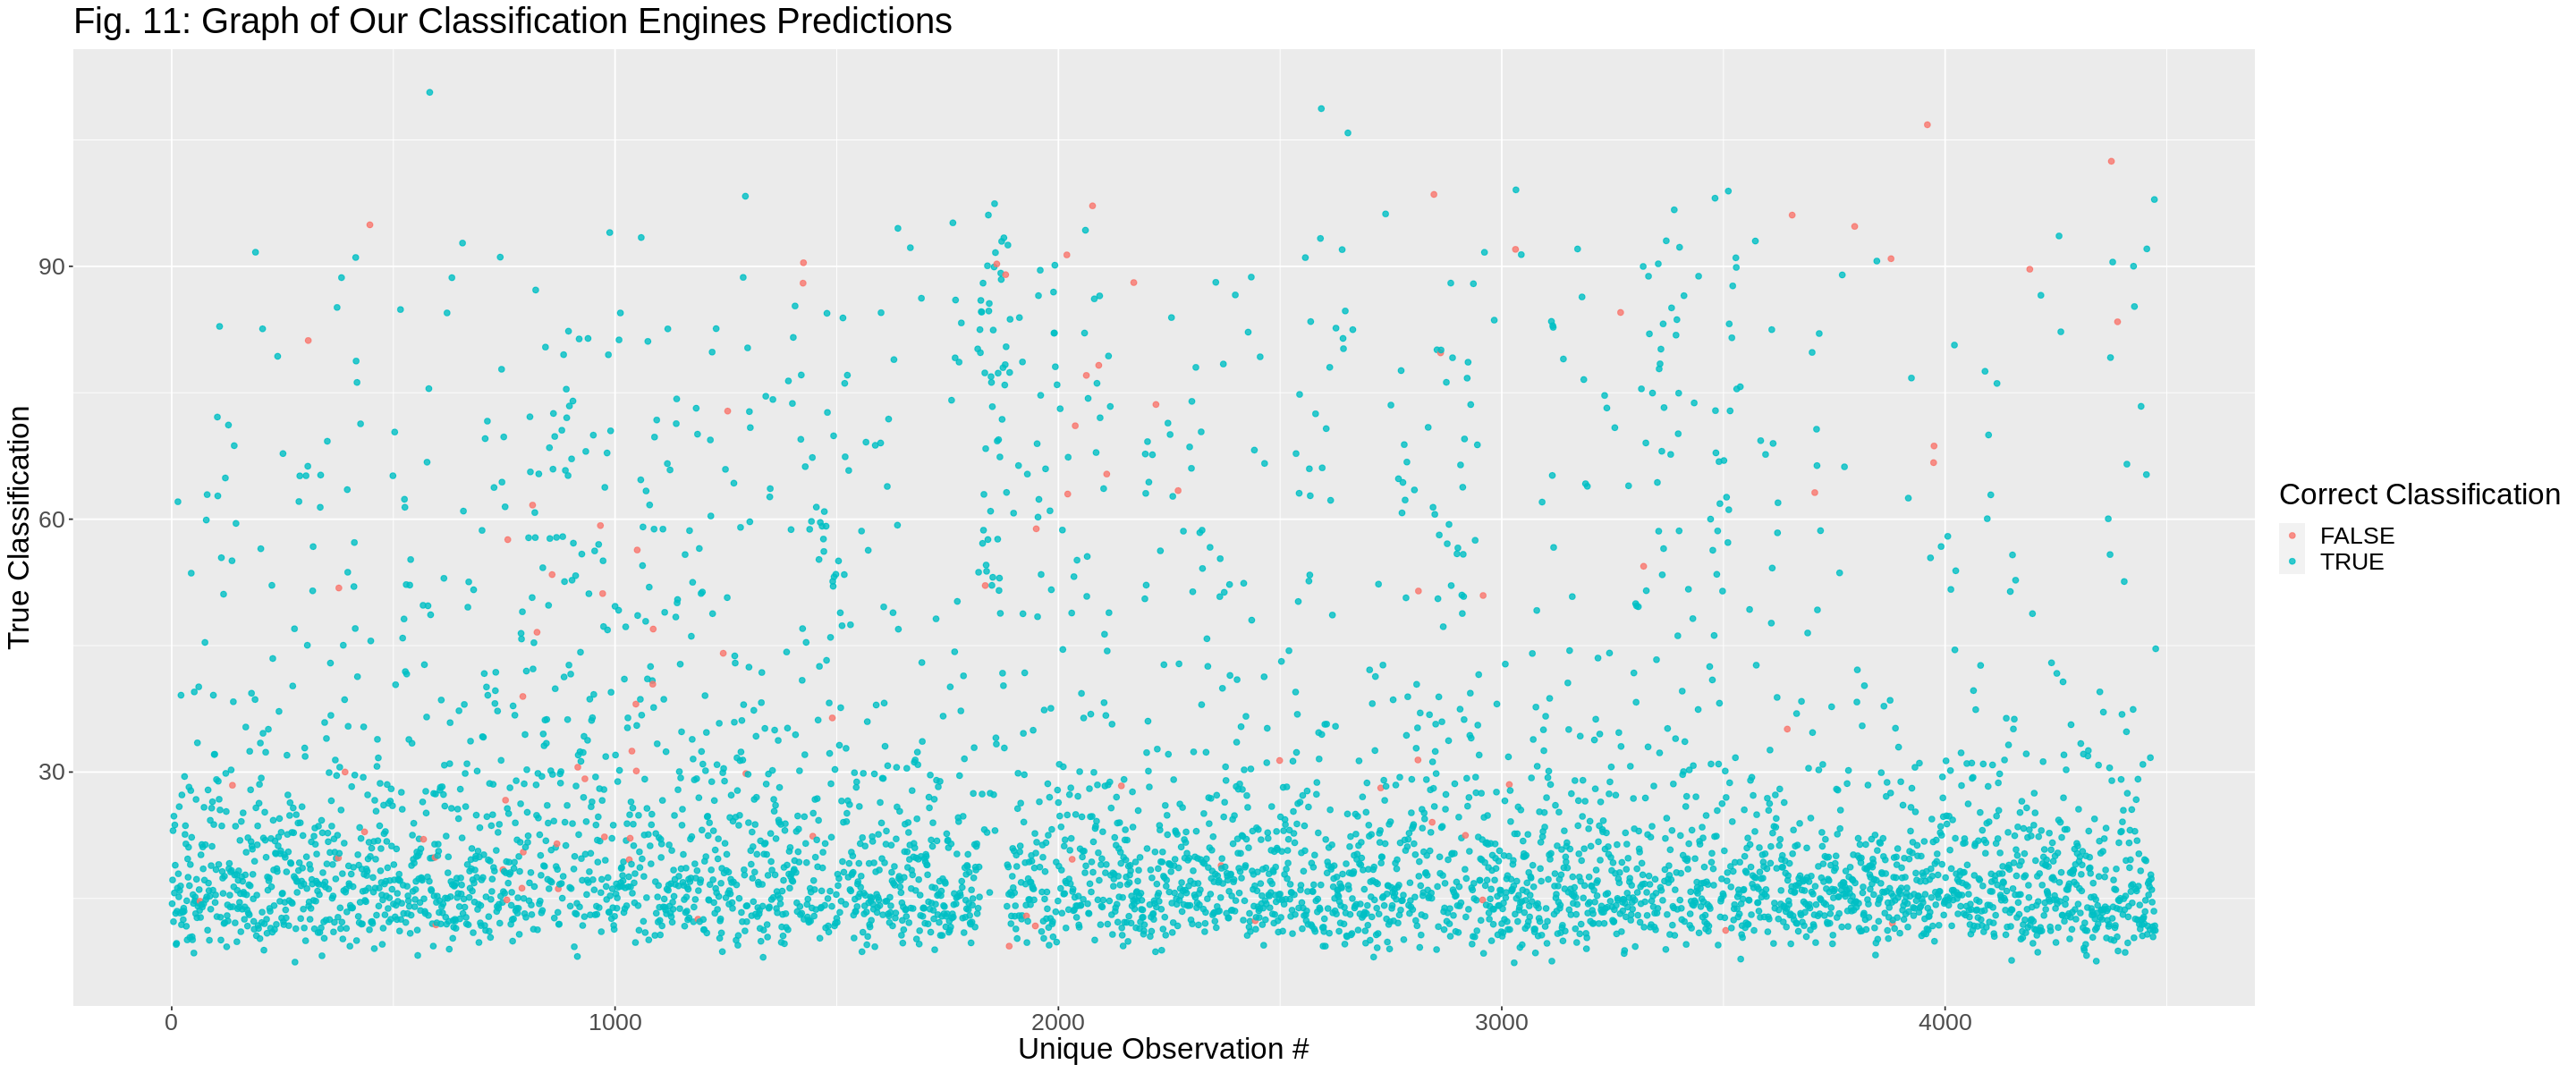

In [13]:
# Showing off our accuracy, confusion matrix, and graph

paste("Table 5: Accuracy of Our KNN Classification Engine")
accuracy
paste("Table 6: Confusion Matrix of Our KNN Classification Engine")
confusion_matrix
pulsar_graph

## Final Analysis Of Our KNN Classification Model

So our KNN Classification model has about a 97.9% accuracy when guessing pulsar stars based off of our predictors, in our test it had made 4383 correct predictions, while it made 27 false positives and 65 false negatives. We can see this too in the graph, as the number of blue dots (correct guesses) massively outnumbers the number of red dots (incorrect guesses). However, in reality our classification model is actually not as good as it first seems. The reason our accuracy is so high is because our data was skewed with non-pulsar star observations outnumbering our pulsar star observations by a large proportion. If we were to take the accuracy of each section of our confusion matrix, i.e the accuracy when just guessing for non-pulsar stars, and the accuracy for guessing just for pulsar stars; we see that our accuracy becomes 99.34% for guessing non-pulsar stars, and 83.07% for guessing pulsar stars. When all we care about is getting pulsar stars correct, this model becomes a lot worse as the accuracy of the thing we care about goes down from what seems to be a extremely high 97.94% accuracy to 83.07% This brings us to why we did not upsample even though we knew our dataset was skewed and could lead to a worse model.

The first reason is it is difficult to implement upscaling, sometimes your model may be good enough without upscaling to use. This brings us to our second point, even though our model is not as perfect as we initially thought, it is still quite good as even the lowest end of the accuracy at 83.07% is relatively high. Our final reason to not upscale is that by upscaling we could potentially give our pulsar stars too much voting power, which in result actually would create a worse model overall.


## Discussion

What we found while creating this project / classification engine are the types of methods to go about creating a good KNN classification engine from scratch, what a pulsar star is, many methods for visualization, and overall a better understanding of R and how to wrangle data as a whole. We also found out how well our KNN classification engine performed on our test data and how much this project improved our data science and R skills, which was to say was much better then we had expected.

The reason it was much better than we had expected is that what we had expected to find was a very plain and easy copy and paste project where all of our code would be regurgitated from our worksheets / tutorials / textbook, with 0 thinking involved. However what we had found was quite far from that. While we still used the same base code from our worksheets / tutorials / textbook, we had to put a lot of thought into how exactly to use the code, as it wasn't stated what variables to choose, or the K value we needed to use. This allowed for us to improve our critical thinking skills, R skills, and other general data science abilities. Another thing we had not expected to find was that our KNN classification engine had such good accuracy. We expected a low 50-60% accuracy as the predicting of pulsar stars seemed to be a difficult problem that such a simple algorithm could not do well. However, our expectations were crushed when we made our final KNN classification engine and collected its accuracy. It was a staggering 97.9% on the high end and a still relatively high 83.07% accuracy after some further thinking. Even though its accuracy was worse than the initial value we collected, it was still way higher than what we expected.

The impact of these findings can help us in future group projects, data sciences courses, coding in R, and most importantly real life uses. This method can be used to determine if the stars that are discovered are pulsar or not. This method is efficient and fast, and it would have benefits for scientists. We can change the model and use a similar code to determine the types of different stars. We arranged the data into sequences according to their common characteristics and used the information to label the data as a pulsar or not pulsar. This technique could be used for other data as well.

Some future questions that came out of making this project were how to improve our model, as obviously we thought a higher accuracy model would get us a better mark (this doesn't seem to be the case anymore from you Q&A), how else could we have approached this classification question which included trying with a different engine or different predictors as our variables, and lastly what could we have done to better improve our visualization of our classification model. Although the current visualizations are pretty good we thought they could be improved more.


## References

All References Done In A APA7 Style Citation;

UCI Machine Learning Repository: HTRU2 Data Set. (n.d.). Archive.ics.uci.edu. https://archive.ics.uci.edu/ml/datasets/HTRU2

Function reference. (n.d.). Ggplot2.Tidyverse.org. https://ggplot2.tidyverse.org/reference/

The Composer of Plots. (n.d.). Patchwork.data-Imaginist.com. Retrieved December 7, 2022, from https://patchwork.data-imaginist.com/index.html

Peng, T. T., Trevor Campbell, and Melissa Lee Foreword by Roger. (n.d.). Data Science. In datasciencebook.ca. Retrieved December 7, 2022, from https://datasciencebook.ca/

omertahi. (2022, November 3). DSCI100_Review_Session/Review Session 2.ipynb at main · omertahi/DSCI100_Review_Session. GitHub. https://github.com/omertahi/DSCI100_Review_Session/blob/main/Review%20Session%202.ipynb

omertahi. (2022, October 4). DSCI100_Review_Session/Review Session.ipynb at main · omertahi/DSCI100_Review_Session. GitHub. https://github.com/omertahi/DSCI100_Review_Session/blob/main/Review%20Session.ipynb

‌Guide to accuracy, precision, and recall. (n.d.). Mage. https://www.mage.ai/blog/definitive-guide-to-accuracy-precision-recall-for-product-developers

‌Posit. (n.d.). Posit. https://posit.co/resources/cheatsheets/

‌EarthSky | What’s a pulsar and why does it pulse? (2022, July 15). Earthsky.org. https://earthsky.org/space/what-is-a-pulsar/

‌Calla Cofield. (2016, April 22). What Are Pulsars? Space.com; Space. https://www.space.com/32661-pulsars.html

‌Predicting Pulsars with ML Algorithms. (n.d.). Kaggle.com. Retrieved December 7, 2022, from https://www.kaggle.com/code/manchunhui/predicting-pulsars-with-ml-algorithms

‌Delatte, T. (n.d.). Pulsars Detection with HTRU2 Dataset. Thomasdelatte.github.io. https://thomasdelatte.com/2020/04/pulsars/


‌